# Code For clusterization and Ratio of charge 
#### In the first part a new root file with a tree is created, the tree consist of clusters with the following variables:
    "Evt",
    "PositionX",
    "ChargeX",
    "SizeX",
    "PositionY",
    "ChargeY",
    "SizeY",
    "Chamber" #0 per TMM1, 1 per TMM2, 2 per GEM, 


In [1]:
import ROOT
import uproot
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from array import array
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.28/06


In [2]:
branchNames = [
    "Evt",
    "PositionX",
    "ChargeX",
    "SizeX",
    "PositionY",
    "ChargeY",
    "SizeY",
    "Chamber", #0 per TMM1, 1 per TMM2, 2 per GEM, 
]

strip_features = [
    "position",
    "charge"
]

cluster_features = [
    'position',
    'charge',
    'size'
]

chamber = [ "Tmm-Lecce1",
            "Tmm-Lecce2",
            "Tracking-GEM1"
]


In [3]:
name = ["run99_xtalk_xtalk2_new", "run99_new"]
file_name="cluster_"+name[1]+".root"

In [ ]:
f = ROOT.TFile(file_name, "RECREATE")
f.Close()

In [ ]:
def cluster(df):
    df.sort_values(by=[strip_features[0]], inplace = True)
    df['Pos_diff'] = (df[strip_features[0]].diff(-1)).abs()
    #print(df.to_string())
    new_pos = []
    new_charge = []
    new_count = []
    current_pos = 0 
    current_charge = 0
    count = 0

    for index, row in df.iterrows():
        if row['Pos_diff'] == 1:
            current_charge += row[strip_features[1]]
            current_pos += row[strip_features[0]]*row[strip_features[1]]
            count=count+1
        else:
            current_charge += row[strip_features[1]]
            current_pos += row[strip_features[0]]*row[strip_features[1]]
            count=count+1
            new_pos.append(current_pos / current_charge)
            new_charge.append(current_charge)
            new_count.append(count)
            current_pos = 0
            current_charge = 0
            count = 0

    result_df = pd.DataFrame({cluster_features[0]: new_pos, cluster_features[1]: new_charge, cluster_features[2]: new_count})

    result_df[cluster_features[0]] = result_df[cluster_features[0]].round(2)
    return result_df


In [ ]:
def get_cluster_from_root(rootFileName, lable):
    file = ROOT.TFile(rootFileName, "READ")
    tree = file.Get("apv_raw")
    
    mmStrip = ROOT.std.vector(ROOT.Int_t())()
    mmChamber = ROOT.std.vector(str)()
    raw_q = ROOT.std.vector(ROOT.std.vector(ROOT.Short_t()))()
    max_q = ROOT.std.vector(ROOT.Short_t())()
    mmReadout = ROOT.std.vector(ROOT.Char_t)()

    tree.SetBranchAddress("mmStrip", ROOT.AddressOf(mmStrip))
    tree.SetBranchAddress("mmChamber", ROOT.AddressOf(mmChamber))
    tree.SetBranchAddress("raw_q", ROOT.AddressOf(raw_q))
    tree.SetBranchAddress("max_q", ROOT.AddressOf(max_q))
    tree.SetBranchAddress("mmReadout", ROOT.AddressOf(mmReadout))


    numEntries = tree.GetEntries()

    file2 = ROOT.TFile(file_name, "UPDATE")
    new_tree = ROOT.TTree(f"clustertree_{lable}", "New Tree")
    branch_data = [array('d', [0.0]) for _ in range(len(branchNames))]

    for i, n in enumerate(branchNames):
        new_tree.Branch(n, branch_data[i], f"{n}/D")
    print("Event: ", end="...")

    entryToRemove = []
    
    for entry in range(numEntries):
        if(entry%28 != 0 or entry==0):
            print(entry, end="...")
        else:
            print(entry)
        tree.GetEntry(entry)
        dfX = []
        dfY = []
        
        #print(len(mmChamber), len(mmReadout), len(mmStrip), len(max_q))
        
        for j in range(len(chamber)):
            dfX.append(pd.DataFrame(columns=strip_features))
            if j<3:
                dfY.append(pd.DataFrame(columns=strip_features))
        
        for i in range(len(mmStrip)):
            for j in range(len(chamber)):
                if(mmChamber[i]==chamber[j] and max_q[i]>0):
                    if(mmReadout[i]=='X'):
                        dfX[j].loc[len(dfX[j])]=[mmStrip[i],max_q[i]]
                    if(mmReadout[i]=='Y'):
                        dfY[j].loc[len(dfY[j])]=[mmStrip[i],max_q[i]]
        
        for j in range(len(chamber)):
            dfX[j] = cluster(dfX[j])
            if j<3:
                dfY[j] = cluster(dfY[j])
        
        #print(dfX[0].to_string())
        
        #print(row_max)
        for j in range(len(chamber)):
            branchFill = []
            branchFill.append(entry)
            if len(dfX[j])>0:
                ind_maxX = dfX[j][cluster_features[1]].idxmax()
                row_maxX = dfX[j].loc[ind_maxX]
                posX=row_maxX[cluster_features[0]]
                chX=row_maxX[cluster_features[1]]
                sizeX=row_maxX[cluster_features[2]]
            else:
                posX=0
                chX=0
                sizeX=0
            branchFill.append(posX)
            branchFill.append(chX)
            branchFill.append(sizeX)
            if (j<3 and len(dfY[j])>0):
                ind_maxY = dfY[j][cluster_features[1]].idxmax()
                row_maxY = dfY[j].loc[ind_maxY]
                posY=row_maxY[cluster_features[0]]
                chY=row_maxY[cluster_features[1]]
                sizeY=row_maxY[cluster_features[2]]
            else:
                posY=0
                chY=0
                sizeY=0
            branchFill.append(posY)
            branchFill.append(chY)
            branchFill.append(sizeY)
            branchFill.append(j)
            for i in range(len(branchNames)):
                branch_data[i][0] = branchFill[i]
            new_tree.Fill()
    new_tree.Write()
    file2.Close()
    file.Close() 

In [ ]:
get_cluster_from_root("/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_IN/"+name[0]+".root", "post")
get_cluster_from_root("/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_IN/"+name[1]+".root", "pre")

## Plot from tree variables
### Correlation matrices

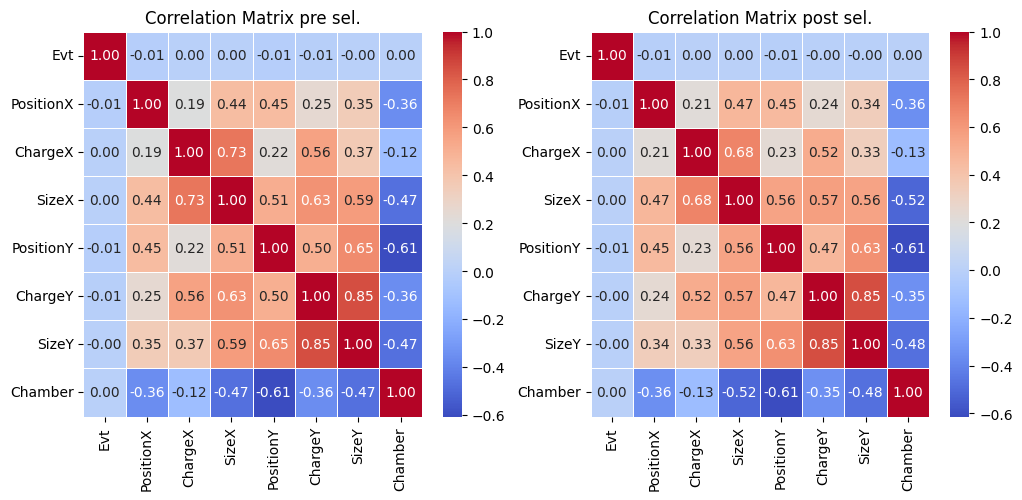

In [4]:
file = uproot.open(file_name)  

tree_pre = file["clustertree_pre"]
tree_post = file["clustertree_post"]

data_pre = tree_pre.arrays(library="pd")
data_post = tree_post.arrays(library="pd")

correlation_matrix_pre = data_pre.corr()
correlation_matrix_post = data_post.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(correlation_matrix_pre, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, ax=ax1)
ax1.set_title('Correlation Matrix pre sel.')

sns.heatmap(correlation_matrix_post, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, ax=ax2)
ax2.set_title('Correlation Matrix post sel.')

plt.show()

### Plot from pre-selections tree

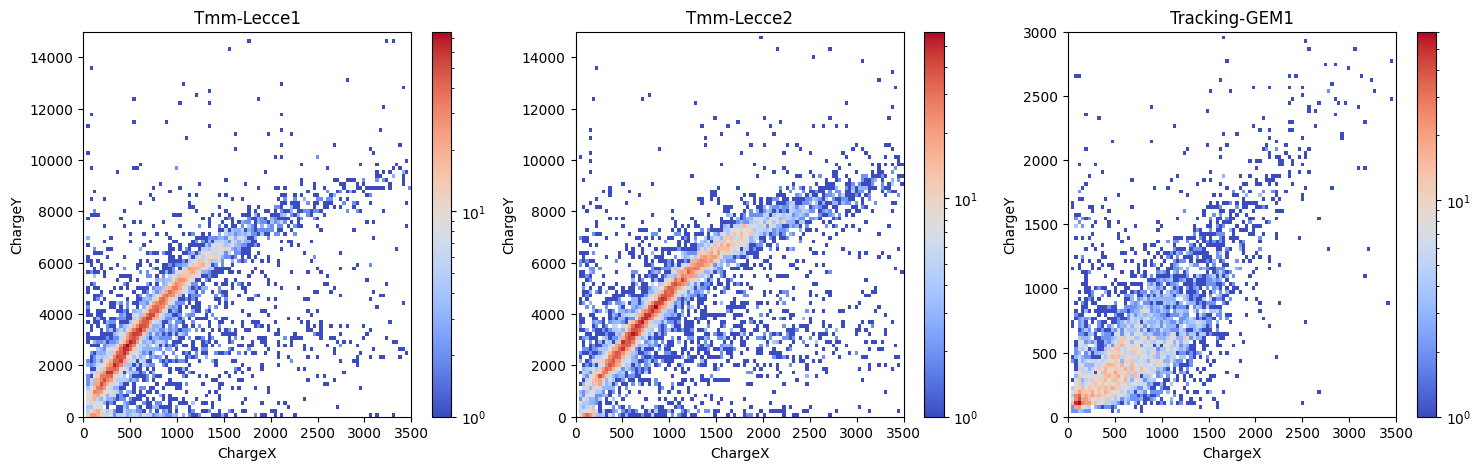

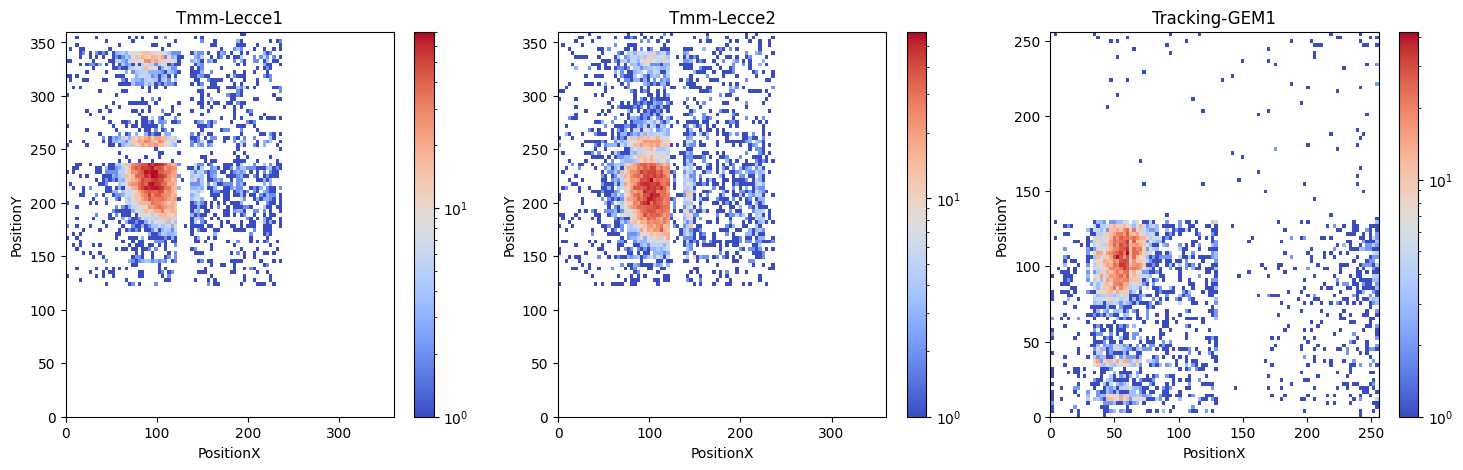

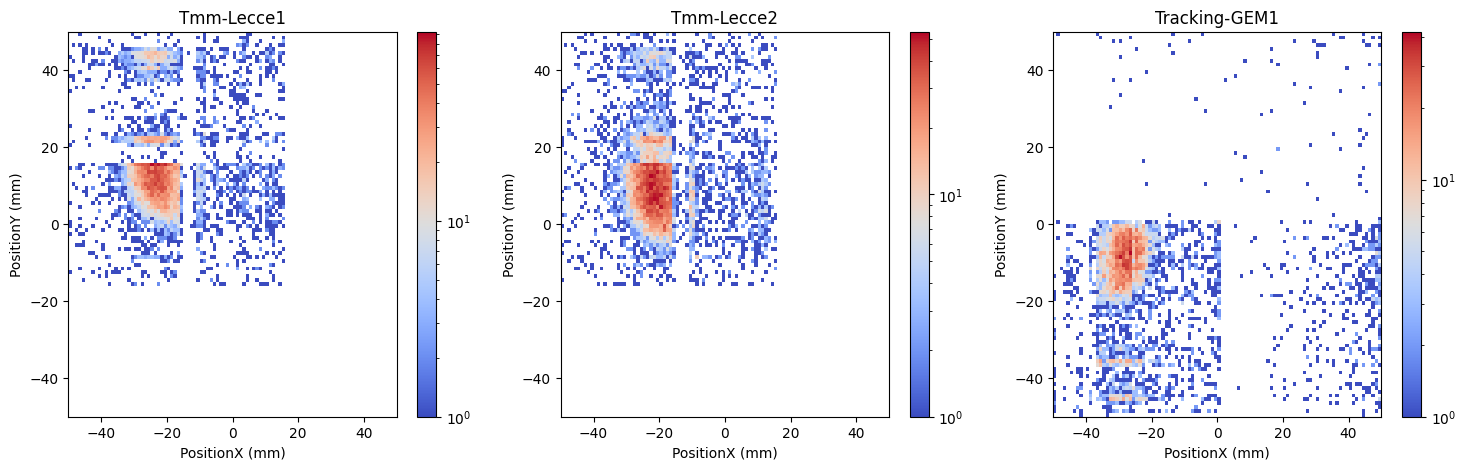

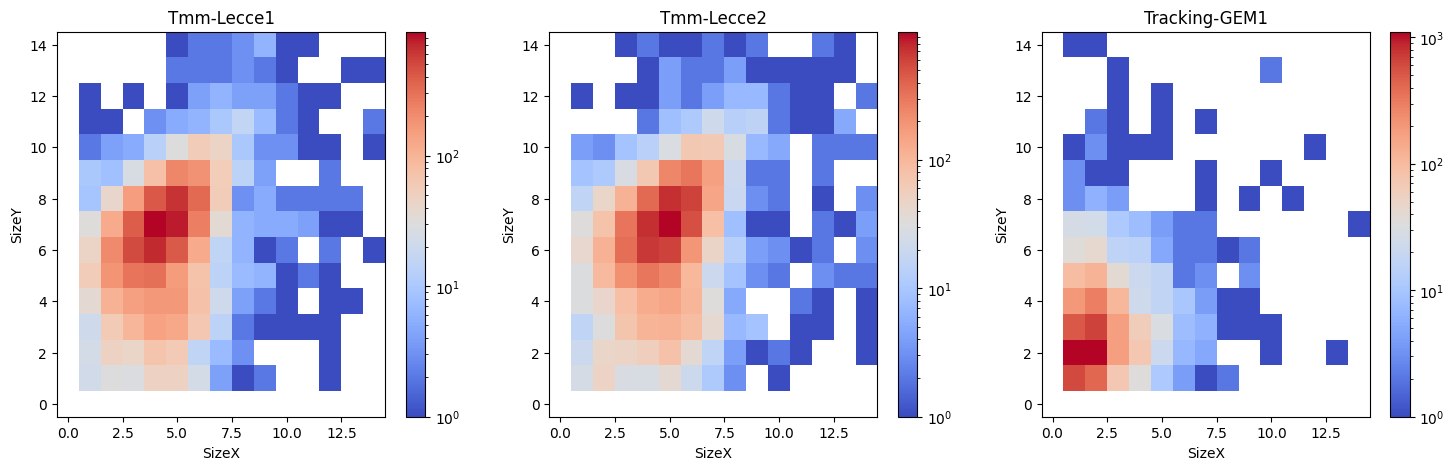

In [33]:
group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    maxY = 15000
    if(idx==2):
        maxY= 3000
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    hist1 = ax.hist2d(group[branchNames[2]], group[branchNames[5]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 3500], [0, maxY]])
    ax.set_xlabel(branchNames[2])
    ax.set_ylabel(branchNames[5])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 256], [0, 256]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 360], [0, 360]])
    ax.set_xlabel(branchNames[1])
    ax.set_ylabel(branchNames[4])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]]*50/128-50, group[branchNames[4]]*50/128-50, bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-50, 50], [-50, 50]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]]*50/179 -50, group[branchNames[4]]*50/179 -50, bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-50, 50], [-50, 50]])
    ax.set_xlabel(branchNames[1]+" (mm)")
    ax.set_ylabel(branchNames[4]+" (mm)")
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    hist1 = ax.hist2d(group[branchNames[3]], group[branchNames[6]], bins=15, cmap='coolwarm', norm=LogNorm(), range=[[-0.5, 14.5], [-0.5, 14.5]])
    ax.set_xlabel(branchNames[3])
    ax.set_ylabel(branchNames[6])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()


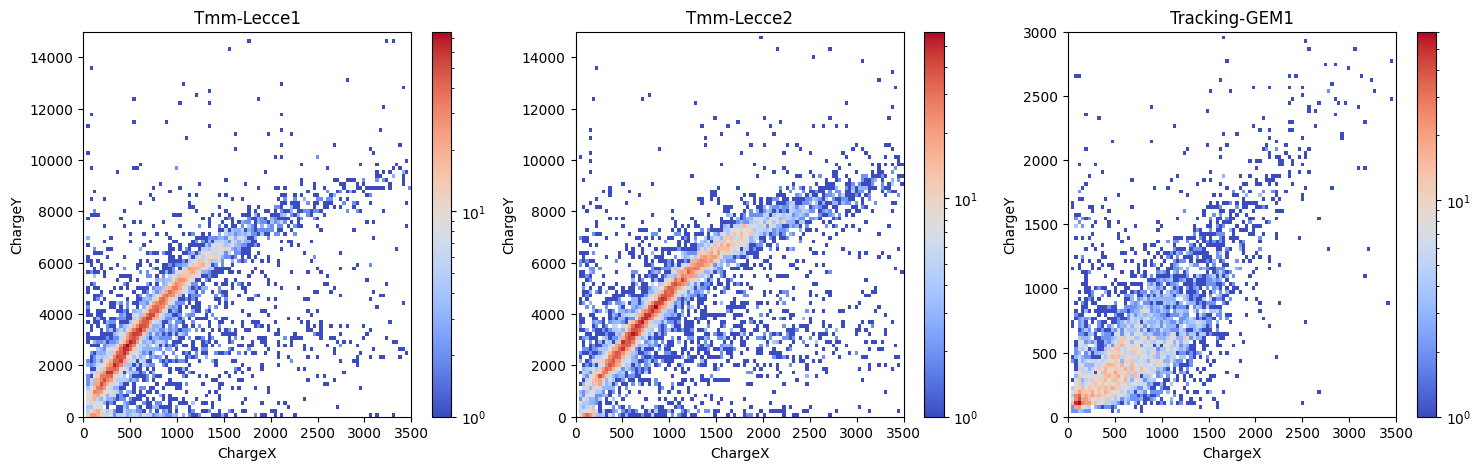

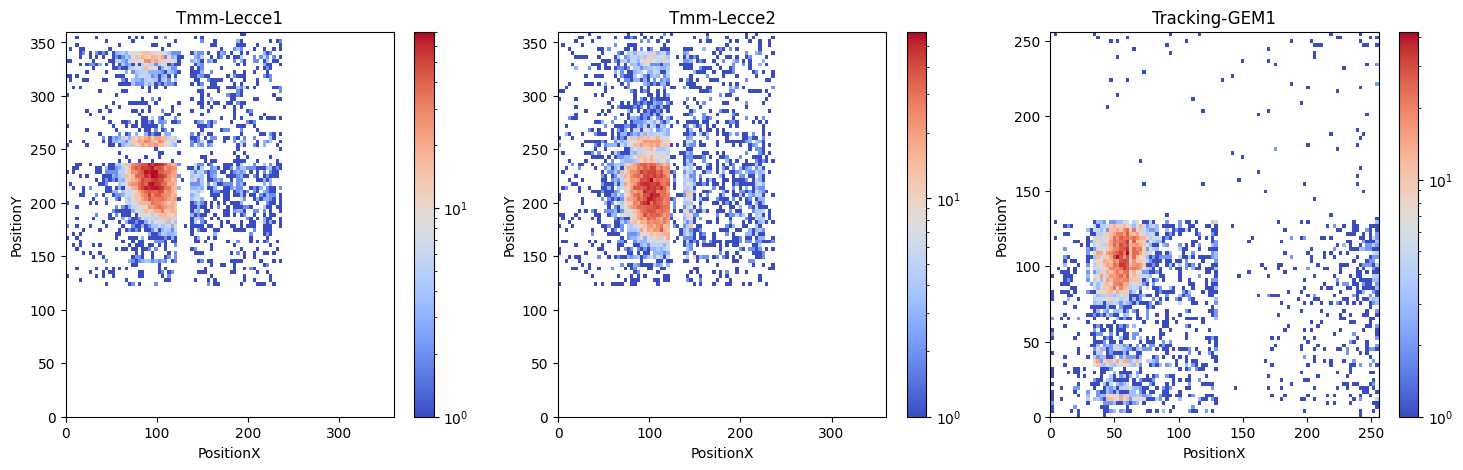

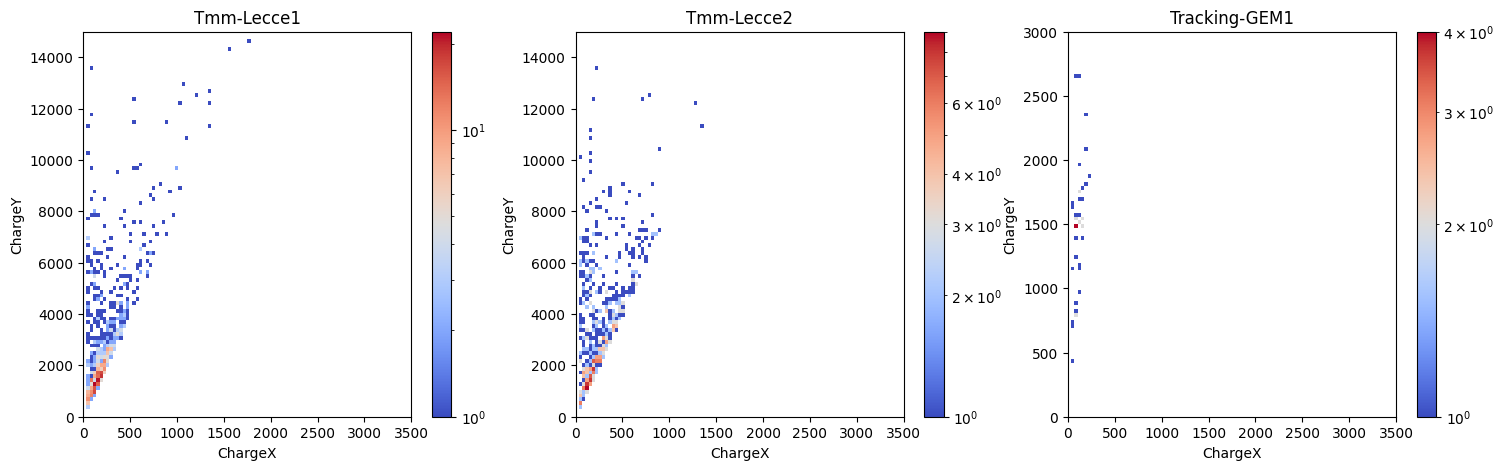

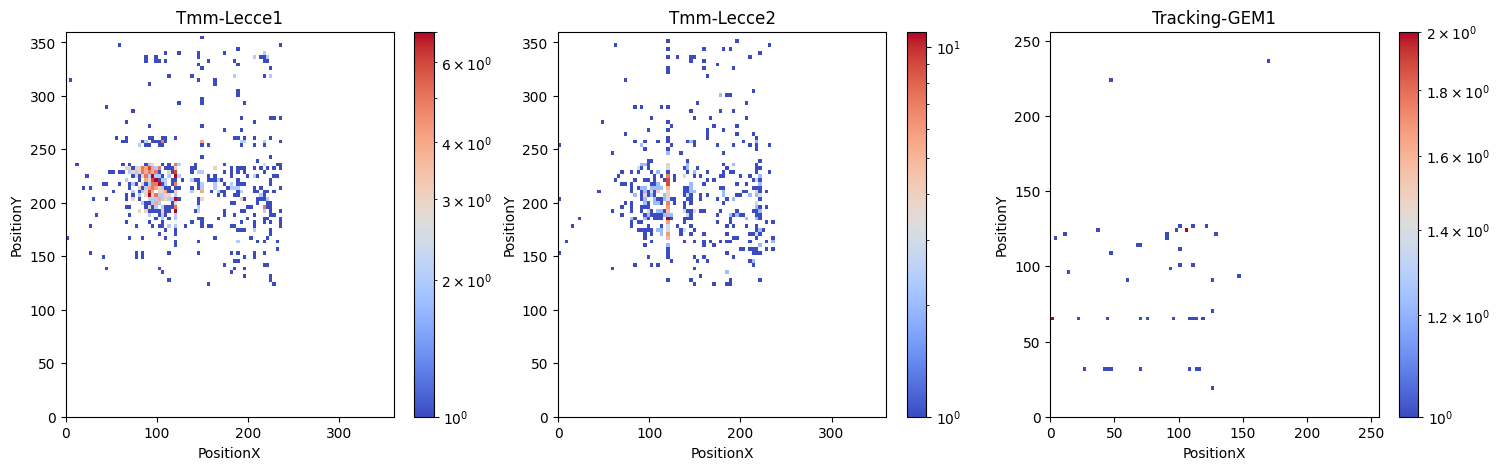

In [40]:
group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    maxY = 15000
    if(idx==2):
        maxY= 3000
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    hist1 = ax.hist2d(group[branchNames[2]], group[branchNames[5]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 3500], [0, maxY]])
    ax.set_xlabel(branchNames[2])
    ax.set_ylabel(branchNames[5])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 256], [0, 256]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 360], [0, 360]])
    ax.set_xlabel(branchNames[1])
    ax.set_ylabel(branchNames[4])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    maxY = 15000
    if(idx==2):
        maxY= 3000
    #group = group[group[branchNames[2]] > 500]
    #group = group[group[branchNames[5]] > 2000]
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]

    group = group[group[branchNames[5]]/group[branchNames[2]]>8]

    hist1 = ax.hist2d(group[branchNames[2]], group[branchNames[5]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 3500], [0, maxY]])
    ax.set_xlabel(branchNames[2])
    ax.set_ylabel(branchNames[5])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_pre.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    #group = group[group[branchNames[2]] > 500]
    #group = group[group[branchNames[5]] > 2000]
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]

    group = group[group[branchNames[5]]/group[branchNames[2]]>8]

    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 256], [0, 256]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 360], [0, 360]])
    ax.set_xlabel(branchNames[1])
    ax.set_ylabel(branchNames[4])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_pre):
    group['rapporto'] = group[branchNames[5]] / group[branchNames[2]]
    group['rapporto'] = group['rapporto'].replace([np.inf, -np.inf], 999)
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    val=6
    if(idx==2):
        val=3
    hist1 = ax.hist(group['rapporto'], bins=100, range=[0, val])
    string = branchNames[5]+"/"+branchNames[2]
    ax.set_xlabel(string)
    ax.set_title(chamber[idx])

plt.show()

### Plot from post-selections tree
#### ChargeX vs Charge Y

In [ ]:
group_post = data_post.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    maxY = 15000
    if(idx==2):
        maxY= 3000
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    hist1 = ax.hist2d(group[branchNames[2]], group[branchNames[5]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 3500], [0, maxY]])
    ax.set_xlabel(branchNames[2])
    ax.set_ylabel(branchNames[5])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_post.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 256], [0, 256]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]], group[branchNames[4]], bins=100, cmap='coolwarm', norm=LogNorm(), range=[[0, 360], [0, 360]])
    ax.set_xlabel(branchNames[1])
    ax.set_ylabel(branchNames[4])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_post.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    if(idx==2):
        hist1 = ax.hist2d(group[branchNames[1]]*50/128-50, group[branchNames[4]]*50/128-50, bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-50, 50], [-50, 50]])
    else:
        hist1 = ax.hist2d(group[branchNames[1]]*50/179 -50, group[branchNames[4]]*50/179 -50, bins=100, cmap='coolwarm', norm=LogNorm(),range=[[-50, 50], [-50, 50]])
    ax.set_xlabel(branchNames[1]+" (mm)")
    ax.set_ylabel(branchNames[4]+" (mm)")
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()

group_post = data_post.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    #if(idx==2):
    group = group[group[branchNames[2]] != 0]
    group = group[group[branchNames[5]] != 0]
    hist1 = ax.hist2d(group[branchNames[3]], group[branchNames[6]], bins=15, cmap='coolwarm', norm=LogNorm(), range=[[-0.5, 14.5], [-0.5, 14.5]])
    ax.set_xlabel(branchNames[3])
    ax.set_ylabel(branchNames[6])
    ax.set_title(chamber[idx])
    plt.colorbar(hist1[3], ax=ax)
plt.show()


#### Charge Y / Charge X

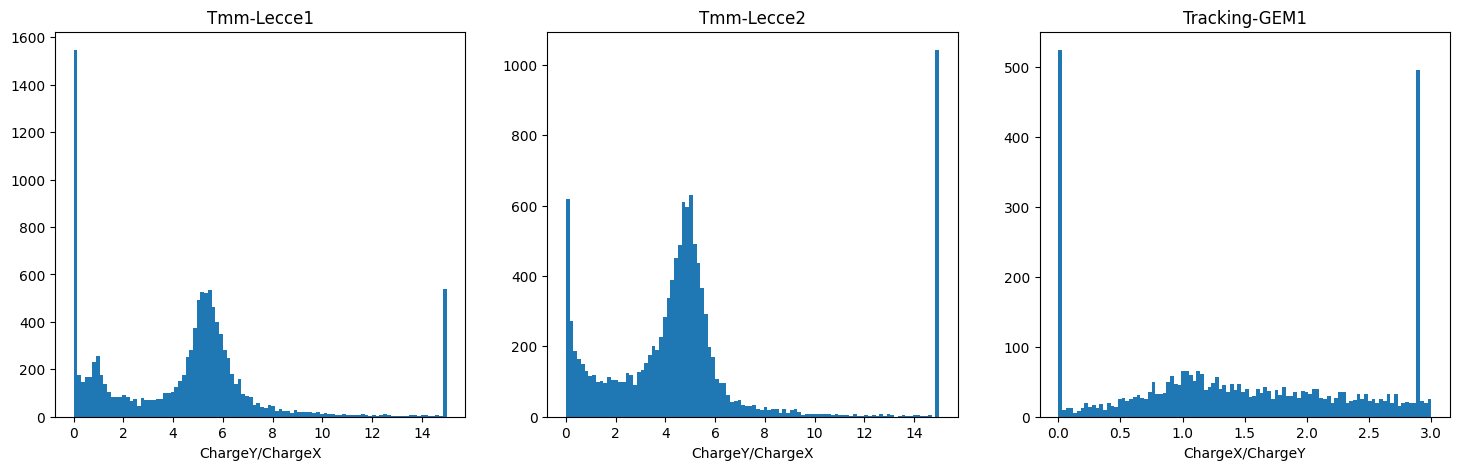

In [23]:
group_post = data_post.groupby(branchNames[7])
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    val=15
    if(idx==2):
        val=3
        group['rapporto'] = group[branchNames[2]] / group[branchNames[5]]
        string = branchNames[2]+"/"+branchNames[5]
    else:
        group['rapporto'] = group[branchNames[5]] / group[branchNames[2]]
        string = branchNames[5]+"/"+branchNames[2]
    group['rapporto'] = group['rapporto'].replace([np.inf, -np.inf], val-0.1)
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    hist1 = ax.hist(group['rapporto'], bins=100, range=[0, val])
    #hist1 = ax.hist2d(group['rapporto'], group[branchNames[2]], norm=LogNorm(), bins=15, cmap='coolwarm',range=[[0, val], [0, 5000]])

    ax.set_xlabel(string)
    ax.set_title(chamber[idx])

plt.show()

#### Charge max / Charge min (max and min between charge X and Y)

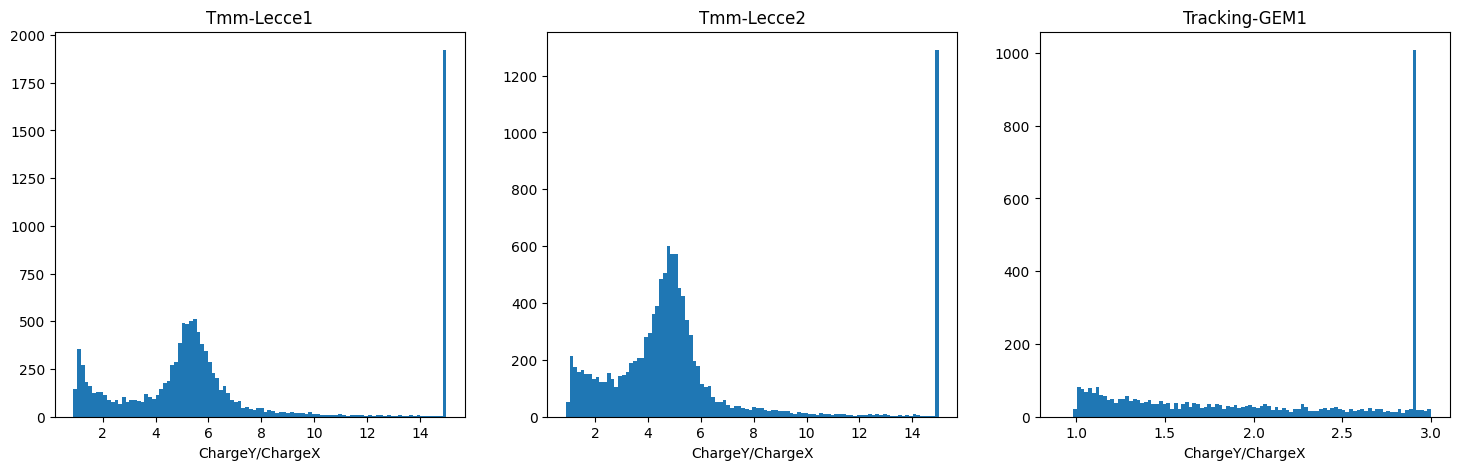

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (chamb, group) in enumerate(group_post):
    group['max'] = group[[branchNames[5], branchNames[2]]].max(axis=1)
    group['min'] = group[[branchNames[5], branchNames[2]]].min(axis=1)
    group['rapporto'] = group['max'] / group['min']
    val=15
    if(idx==2):
        val=3
    group['rapporto'] = group['rapporto'].replace([np.inf, -np.inf], val-0.1)
    ax = axes[idx]  # Get the current subplot from axes
    group = group.drop(branchNames[7], axis=1)
    hist1 = ax.hist(group['rapporto'], bins=100, range=[0.9, val])
    string = branchNames[5]+"/"+branchNames[2]
    ax.set_xlabel(string)
    ax.set_title(chamber[idx])

plt.show()



## Removing events from the tree based on the ChargeY/ChargeX ratio:
#### We are selecting events with 1<ChargeY/ChargeX<12 in both TMMs

In [ ]:
data_post_copy = data_post.copy()
data_post_copy = data_post_copy[data_post_copy['Chamber'] != 2]
len_inital = len(data_post_copy)/2
#print(len_inital)
data_post_copy['rapporto'] = data_post_copy[branchNames[5]] / data_post_copy[branchNames[2]]
data_post_copy['rapporto'] = data_post_copy['rapporto'].replace([np.inf, -np.inf], 15)

condition = (data_post_copy['rapporto'] > 1) & (data_post_copy['rapporto'] < 12)

data_post_copy = data_post_copy[condition]

conteggio_valori = data_post_copy['Evt'].value_counts()
righe_da_rimuovere = data_post_copy[data_post_copy['Evt'].map(conteggio_valori) == 1]
data_post_copy = data_post_copy.drop(righe_da_rimuovere.index)

print("Percentage of remaining events: ", len(data_post_copy)/2, "/", len_inital, "=", round(((len(data_post_copy)/len_inital)*50),2), "%")
#print(data_post_copy)

vec_entry = data_post_copy['Evt']
vec_entry = vec_entry.drop_duplicates()
vec_entry = [int(x) for x in vec_entry]
#print(vec_entry)

In [ ]:
def remove_events_by_entry(input_file_name, output_file_name, entries):
    try:
        input_file = ROOT.TFile.Open(input_file_name, "READ")
        if not input_file or input_file.IsZombie():
            raise RuntimeError("Impossibile aprire il file di input.")

        tree = input_file.Get("apv_raw")
        if not tree:
            raise RuntimeError("Impossibile ottenere il tree 'apv_raw' dal file di input.")

        output_file = ROOT.TFile(output_file_name, "RECREATE")
        if not output_file or output_file.IsZombie():
            raise RuntimeError("Impossibile creare il file di output.")

        new_tree = tree.CloneTree(0)

        num_entries = tree.GetEntries()
        for entry in range(num_entries):
            if entry % 28 != 0 or entry == 0:
                print(entry, end="...")
            
            tree.GetEntry(entry)

            if entry in entries:
                new_tree.Fill()

        output_file.cd()
        new_tree.Write()

        input_file.Close()
        output_file.Close()

        print("\nOperazione completata con successo.")

    except Exception as e:
        print("Si è verificato un errore:", str(e))

In [ ]:
remove_events_by_entry("/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_IN/"+name[0]+".root","/Users/marcobuonsante/Downloads/HCAL/Aug_TestBean_File_OUT/"+name[0]+"_cluster_sel.root", vec_entry)